In [1]:
import os
import sys
from pathlib import Path

cwd = Path().parent.resolve()
cwd = cwd.parent.resolve()
print(cwd)
# Change cwd to the parent directory of this script
os.chdir(cwd)


/Users/AnshulSrivastava/Desktop/CoraGNN-Benchmark


In [2]:
import torch
import yaml
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from src.train import Net
from src.data_loader import load_cora

In [8]:
# Load configuration
with open('configs/config.yaml', 'r') as file:
    config = yaml.safe_load(file)

root_dir = config["data"]["root_dir"]
name = config["data"]["name"]
model_type = config["model"]["type"]
hidden_size = config["model"]["hidden_size"]
dropout = config["model"]["dropout"]
gat_heads = config["model"]["gat_heads"]
lr = config["training"]["lr"]
weight_decay = config["training"]["weight_decay"]
epochs = config["training"]["epochs"]
seed = config["training"]["seed"]
interval = config["training"]["interval"]
ckpt_path = config["training"]["ckpt_path_template"].format(model=model_type)
experiment = config["mlflow"]["experiment"]

In [9]:
# Load the model
data = load_cora("data")
model = Net(
    data.num_node_features, 
    hidden_size, 
    data.num_classes, 
    dropout,
    model_type,
    gat_heads
)
model.load_state_dict(torch.load(ckpt_path))
model.eval()

Net(
  (conv1): SAGEConv(1433, 16, aggr=mean)
  (conv2): SAGEConv(16, 7, aggr=mean)
)

In [10]:
# Extract hidden embeddings
with torch.no_grad():
    h = model.conv1(data.x, data.edge_index) # pre-activation hidden
    h = h.cpu().numpy()
    

In [11]:
# Perform t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=seed)
h_tsne = tsne.fit_transform(h)

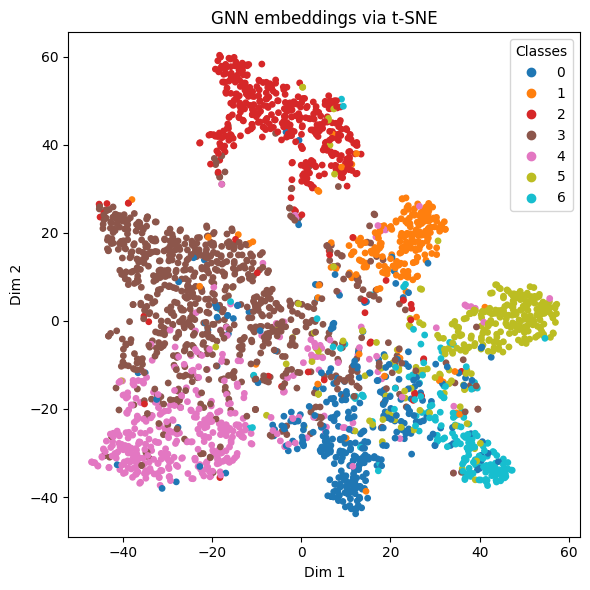

In [12]:
plt.figure(figsize=(6,6))
scatter = plt.scatter(h_tsne[:,0], h_tsne[:,1],
                      c=data.y.cpu(), cmap="tab10", s=15)
plt.legend(*scatter.legend_elements(), title="Classes")
plt.title("GNN embeddings via t-SNE")
plt.xlabel("Dim 1"); plt.ylabel("Dim 2")
plt.tight_layout()
plt.savefig("figures/sage_tsne.png")
plt.show()